# **Pre Classification Analysis** 

In [1]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_final\\code\\preprocessing')

### Set file paths

In [2]:
file_comments = "../../../../data/reddit/Askpolitics_comments.zst"
file_submissions = "../../../../data/reddit/Askpolitics_submissions.zst"

subreddit_here = "Askpolitics"
subreddit = "Askpolitics"


output_path = f"output/{subreddit_here}_new_preprocessing_com_rep.csv"



In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
#import gurobipy
#from gurobipy import *

pd.options.mode.chained_assignment = None

In [4]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import plot_submissions_comments
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

***

## **Data Import**

In [5]:
# import data
data_comments = import_subreddit(file_comments)
data_submissions = import_subreddit(file_submissions)


In [6]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [7]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)

Nr. of pulled submissions 9508


In [8]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)

Nr. of pulled comments & replies 78714


In [9]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

Nr. of comments 29147
Nr. of replies 14192


### Filter relevant submissions

* relevant = above subreddit-average number of comments
* relevant_comments: those with a parent, that is in relevant_submissions

In [10]:
relevant_submissions = pd.DataFrame(comments.groupby('parent_id')['id'].count()).reset_index().rename(columns={'parent_id' : 'submission_id', 'id' : 'count'})
print(relevant_submissions['count'].mean())
relevant_submissions
# get nr of submissions, for which I do have comments --> 29.304


3.548885912577621


,submission_id,count
0,100a6qb,2
1,100g7ul,6
2,100z6pn,4
3,1010brb,5
4,101x3jw,1
...,...,...
8208,zycuup,1
8209,zyi1ad,2
8210,zz8wgk,2
8211,zzg506,2


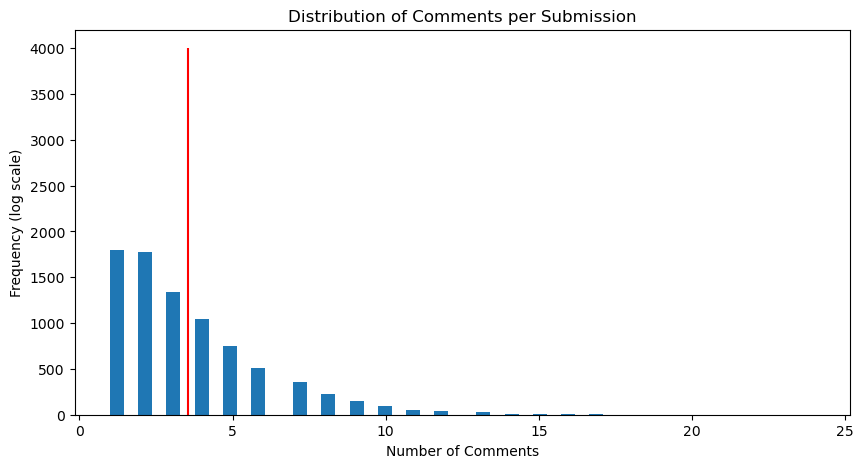

In [11]:
# Histogram
plt.figure(figsize=(10, 5))
plt.hist(relevant_submissions['count'], bins=50)
plt.vlines((relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4000)

#plt.yscale('log')
#plt.xscale('log')
plt.xlabel("Number of Comments")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Comments per Submission")
plt.show()


In [12]:
plt_data = pd.DataFrame(relevant_submissions['count'].value_counts()).rename(columns={'count' : 'class_count'}).reset_index().rename(columns={'count' : 'comment_count'}).sort_values(by = "comment_count").reset_index(drop=True)

plt_data['log_com_count'] = plt_data['comment_count'].apply(lambda x: np.log10(x))
plt_data['log_class_count'] = plt_data['class_count'].apply(lambda x: np.log10(x))
plt_data

,comment_count,class_count,log_com_count,log_class_count
0,1,1793,0.000000,3.253580
1,2,1772,0.301030,3.248464
2,3,1344,0.477121,3.128399
3,4,1045,0.602060,3.019116
4,5,750,0.698970,2.875061
5,6,507,0.778151,2.705008
6,7,358,0.845098,2.553883
7,8,231,0.903090,2.363612
8,9,151,0.954243,2.178977
9,10,99,1.000000,1.995635


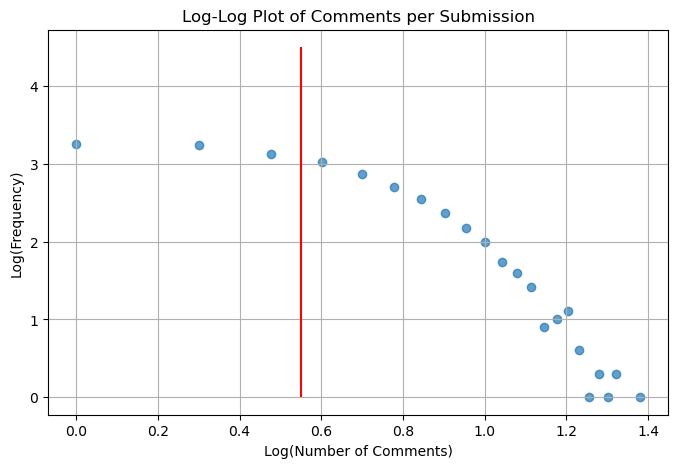

In [13]:
plt.figure(figsize=(8, 5))
plt.scatter(plt_data['log_com_count'], plt_data['log_class_count'], alpha=0.7)
plt.vlines(np.log10(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4.5)

plt.xlabel("Log(Number of Comments)")
plt.ylabel("Log(Frequency)")
plt.title("Log-Log Plot of Comments per Submission")
plt.grid(True)
plt.show()

Text(0, 0.5, 'Nr. of submissions')

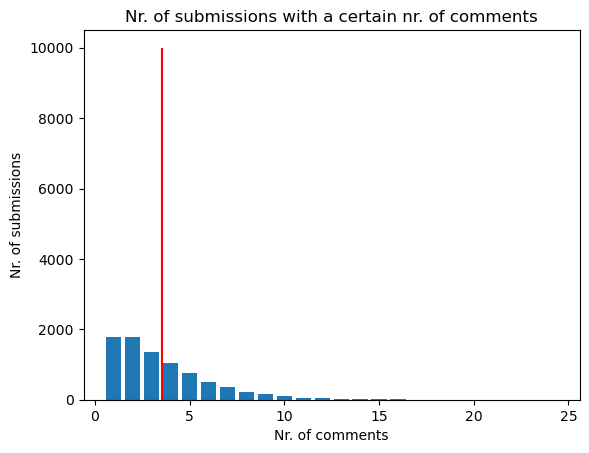

In [14]:
# excluding three submissions with > 100 comments

plt.bar(x = plt_data['comment_count'], height = plt_data['class_count'])
plt.vlines(relevant_submissions['count'].mean(), colors="red", ymin = 0, ymax=10000)
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

Text(0, 0.5, 'Nr. of submissions')

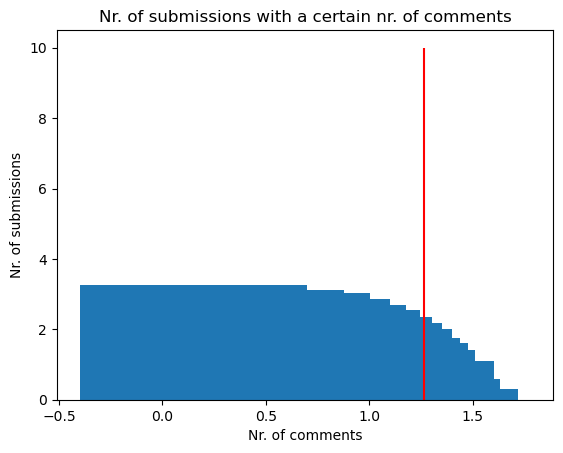

In [15]:
# excluding three submissions with > 100 comments

plt.bar(x = plt_data['log_com_count'], height = plt_data['log_class_count'])
plt.vlines(np.log(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=10)
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

In [16]:
# select relevant submissions (by avg. number of comments)

relevant_submissions, relevant_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")


Mean nr. of comments per submission 3.548885912577621
Nr. of submission, that I have comments for 8213
All submissions found
Removing empty submissions deleted 3297 submissions
Kept 4916 submissions
Nr. of comments, whose submission is retaied 17704
Share 0.6074038494527739


In [17]:

print(f"Number of relevant submissions: {len(relevant_submissions)}")
print("Lost submissions: ", len(submissions) - len(relevant_submissions))

relevant_submissions

relevant_comments.reset_index(drop=True, inplace=True)
relevant_comments

# roughly half

Number of relevant submissions: 4916
Lost submissions:  4592


,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,[deleted],1.317888e+09,l2lpu,2s5s2,"The way I see it, the OWS protests boil down t...",l2lpu,c2pazap,c2pazap,1.0,1,0.0,Askpolitics,NaN,NaN,NaN,NaN,NaN,2011-10-06,comment
1,SteepleMeister,1.318995e+09,lh2ra,2s5s2,I would propose an amendment that would define...,lh2ra,c2smnv6,c2smnv6,2.0,2,0.0,Askpolitics,NaN,NaN,NaN,NaN,NaN,2011-10-19,comment
2,piper82,1.319037e+09,lh2ra,2s5s2,Outlawing abortion.,lh2ra,c2sq9e4,c2sq9e4,0.0,0,0.0,Askpolitics,NaN,NaN,NaN,NaN,NaN,2011-10-19,comment
3,ejduck3744,1.320030e+09,lh2ra,2s5s2,"bad idea, by them having to be re elected ever...",lh2ra,c2vrcut,c2vrcut,1.0,1,0.0,Askpolitics,NaN,NaN,NaN,NaN,NaN,2011-10-31,comment
4,[deleted],1.320472e+09,lh2ra,2s5s2,I think term limits would be more effective.,lh2ra,c2x88w3,c2x88w3,1.0,1,0.0,Askpolitics,NaN,NaN,NaN,NaN,NaN,2011-11-05,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17699,DaSaw,1.703990e+09,18un5u8,2s5s2,"At it's most basic, a lobbyist is someone whos...",18un5u8,kfn8fz9,kfn8fz9,1.0,1,0.0,Askpolitics,NaN,,False,True,NaN,2023-12-31,comment
17700,tnic73,1.704028e+09,18v6zv6,2s5s2,It depends on how you view the political spect...,18v6zv6,kfozima,kfozima,1.0,1,0.0,Askpolitics,NaN,,False,True,NaN,2023-12-31,comment
17701,apollo151,1.704029e+09,18v6zv6,2s5s2,Far-right insofar as the far-right in the poli...,18v6zv6,kfp0ros,kfp0ros,2.0,2,0.0,Askpolitics,NaN,,False,True,NaN,2023-12-31,comment
17702,W_AS-SA_W,1.704035e+09,18v6zv6,2s5s2,No that would be considered tyrannical or dict...,18v6zv6,kfpdcvz,kfpdcvz,1.0,1,0.0,Askpolitics,NaN,,False,True,NaN,2023-12-31,comment


### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 

In [18]:
df_matched = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner', subreddit_here)
df_matched

Nr. of unique replies 8757
Nr. of unique comments 7019
Nr. of unique submissions 3542


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c2smnv6,c2t7ii8,Perfect.,Askpolitics,1.319172e+09,[deleted],1.0,1,0.0,lh2ra,...,SteepleMeister,2.0,2,0.0,1.318995e+09,"I would prevent any Representative, Senator or...",Axemantitan,8.0,6,1.318994e+09
1,c3ajwsf,c3fdl7m,[deleted],Askpolitics,1.326106e+09,[deleted],1.0,1,0.0,nh0sx,...,iammolotov,1.0,1,0.0,1.324645e+09,Please enlighten me.,very_nice_how_much,5.0,4,1.324182e+09
2,c5jr1ep,c5jrgbt,Ah thank you. Great answer. I was writing a pa...,Askpolitics,1.343322e+09,[deleted],1.0,1,0.0,v8kj6,...,[deleted],2.0,2,0.0,1.343320e+09,I have been doing some research on whether par...,[deleted],1.0,1,1.340048e+09
3,c5jo72n,c5k2lfz,"A bigger issue than the political shift would,...",Askpolitics,1.343363e+09,haydensane,2.0,2,0.0,x6egl,...,meelar,3.0,3,0.0,1.343309e+09,Which states would be the most affected? How w...,InnocentAlternate,1.0,1,1.343284e+09
4,c5qzrah,c5r2091,I know I was looking more for more data based ...,Askpolitics,1.344609e+09,Sernando,1.0,1,0.0,xyno1,...,expectantyoke,2.0,2,0.0,1.344595e+09,http://imgur.com/Uiutt\nHow much of these are ...,Sernando,1.0,1,1.344549e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8752,kff8zac,kffuy1h,>He is not legible for office because of treas...,Askpolitics,1.703872e+09,tnic73,1.0,1,0.0,18tpoop,...,space0watch,2.0,2,0.0,1.703864e+09,if you do not know Project 2025 will do will b...,MatteaGunnar,2.0,2,1.703864e+09
8753,kff8zac,kfgaoss,Do you feel the same way about the opponents P...,Askpolitics,1.703878e+09,brendbil,1.0,1,0.0,18tpoop,...,space0watch,2.0,2,0.0,1.703864e+09,if you do not know Project 2025 will do will b...,MatteaGunnar,2.0,2,1.703864e+09
8754,kfh4tz5,kfh5y1s,All good points. But my question still stands....,Askpolitics,1.703890e+09,secondsniglet,1.0,1,0.0,18smc4h,...,matthedev,1.0,1,0.0,1.703889e+09,Why is there so much anticipation about how th...,secondsniglet,1.0,1,1.703742e+09
8755,kfl1jy0,kflitpm,"When you say ""extremists"" from a point of anyw...",Askpolitics,1.703966e+09,FJMMJ,1.0,1,0.0,18ukpy4,...,roastbeeftacohat,1.0,1,0.0,1.703960e+09,"He looks like a British gentleman, so why does...",cryptomelons,1.0,1,1.703957e+09


In [19]:
duplicated = df_matched[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated

,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child



### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [20]:
df_matched['body_child'].value_counts().head(10)

df_matched['body_parent'].value_counts().head(5)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*
# I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

# don't filter based on frequency of a text
# short replies (like thank you), will be removed with len < 5
# frequent comments can just be active comments
# bots are removed by author = [removed]


body_parent
[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [21]:
df = preprocess_texts(data = df_matched, length = 5)
df

Deleting all interactions with empty texts removed 713 interactions. Share:  0.08142057782345552
Kept 8044 interactions.
Deleting empty authors deleted 974 interactions. Share:  0.12108403779214322
Kept 7070 interactions.
Length 5 removes 701 interactions
Kept 6369 interactions
Drop duplicates (in parent & child text and author) removed 0 interactions. Share:  0.0
Kept 6369 interactions.
After text cleaning 6 interactions had empty texts and got removed. Share:  0.0009420631182289214
Kept 6363 interactions.


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c5jo72n,c5k2lfz,"A bigger issue than the political shift would,...",Askpolitics,1.343363e+09,haydensane,2.0,2,0.0,x6egl,...,meelar,3.0,3,0.0,1.343309e+09,Which states would be the most affected? How w...,InnocentAlternate,1.0,1,1.343284e+09
1,c5qzrah,c5r2091,I know I was looking more for more data based ...,Askpolitics,1.344609e+09,Sernando,1.0,1,0.0,xyno1,...,expectantyoke,2.0,2,0.0,1.344595e+09,How much of these are 'true' and to what exte...,Sernando,1.0,1,1.344549e+09
2,c5ybl4k,c5yc6u2,This is all similar stuff to what I've found. ...,Askpolitics,1.345854e+09,Sernando,1.0,1,0.0,xyno1,...,Ridonkulousley,2.0,2,0.0,1.345851e+09,How much of these are 'true' and to what exte...,Sernando,1.0,1,1.344549e+09
3,c66l1tj,c66l5jm,This is bullshit politics at it's finest and w...,Askpolitics,1.347371e+09,flyingbarmitzvah,1.0,1,0.0,zpguc,...,pearlhart,2.0,2,0.0,1.347371e+09,The basis of our support for Israel as far as ...,flyingbarmitzvah,3.0,3,1.347370e+09
4,c67a2lc,c68eogy,As a state employee do you think it will conti...,Askpolitics,1.347682e+09,Ridonkulousley,1.0,1,0.0,zs6jh,...,meelar,3.0,3,0.0,1.347484e+09,Just curious. Thanks for taking the time to re...,will_at_work,5.0,5,1.347480e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6358,kff8zac,kffuy1h,He is not legible for office because of treaso...,Askpolitics,1.703872e+09,tnic73,1.0,1,0.0,18tpoop,...,space0watch,2.0,2,0.0,1.703864e+09,if you do not know Project 2025 will do will b...,MatteaGunnar,2.0,2,1.703864e+09
6359,kff8zac,kfgaoss,Do you feel the same way about the opponents P...,Askpolitics,1.703878e+09,brendbil,1.0,1,0.0,18tpoop,...,space0watch,2.0,2,0.0,1.703864e+09,if you do not know Project 2025 will do will b...,MatteaGunnar,2.0,2,1.703864e+09
6360,kfh4tz5,kfh5y1s,All good points. But my question still stands....,Askpolitics,1.703890e+09,secondsniglet,1.0,1,0.0,18smc4h,...,matthedev,1.0,1,0.0,1.703889e+09,Why is there so much anticipation about how th...,secondsniglet,1.0,1,1.703742e+09
6361,kfl1jy0,kflitpm,When you say extremists from a point of anywhe...,Askpolitics,1.703966e+09,FJMMJ,1.0,1,0.0,18ukpy4,...,roastbeeftacohat,1.0,1,0.0,1.703960e+09,"He looks like a British gentleman, so why does...",cryptomelons,1.0,1,1.703957e+09


In [22]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


## **Check for Mods**

In [34]:
df['author_submission'].value_counts()[:20]

author_submission
DaveDragon11075         115
FaisalAli_91            115
TRIGGEREDharambe2018     71
AgentP-501_212           53
yeeto5o5                 35
kiwiheretic              35
lochnessthemonster       34
PinkPropaganda           33
TheFunkyBunny            32
javascript_dev           31
ShotsOfAutism            31
Passion_For_Learning     29
mikerichh                28
ThrowRA73000             26
ParticularGlass1821      25
ChibiDecker              25
Ok-Story-9319            23
Vexra                    21
SnugFnuggBlue            20
WeWannaKnow              20
Name: count, dtype: int64

In [33]:
df['author_parent'].value_counts()[:20]

author_parent
SovietRobot            156
brendbil               153
LabTech41              113
loselyconscious         97
Dammit_Banned_Again     79
limbodog                79
Ruar35                  78
Nadieestaaqui           76
VVillyD                 73
TrumpChooChooTrain      72
27SwingAndADrive        70
I_Need_Sources          66
robbini3                60
roastbeeftacohat        57
billiarddaddy           54
RowdyPants              54
cos                     53
writesgud               52
Sion_nois06             52
RedRemote45             52
Name: count, dtype: int64

In [32]:
df['author_child'].value_counts()[:20]

author_child
FaisalAli_91            91
loselyconscious         91
DaveDragon11075         89
brendbil                46
clocks_for_sale         45
RowdyPants              43
I_Need_Sources          43
SovietRobot             41
mikerichh               39
locri                   38
Quarter_Twenty          36
LabTech41               35
limbodog                35
DaSaw                   34
hrs922                  33
SexyDoorDasherDude      33
TRIGGEREDharambe2018    32
Dammit_Banned_Again     30
writesgud               28
PinkPropaganda          28
Name: count, dtype: int64

In [ ]:

# print("Child", len(df[df['author_child'] == 'AutoModerator']))
# print("Parent", len(df[df['author_parent'] == 'AutoModerator']))
# print("Submission", len(df[df['author_submission'] == 'AutoModerator']))

# len(df)

Child 567
Parent 4
Submission 31


9312

In [ ]:
# df[df['author_child'] == "AutoModerator"]['body_child'].value_counts()

body_child
Your comment was removed because you do not have a user flair. We require members to have a user flair to participate on this sub. For instructions on how to add a user flair click here I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.                                                                                                                         545
Your comment was removed for being uncivilized, which breaks our rules. We encourage you to repost your comment in a more civilized manner. I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.                                                                                                                                                                        16
Your post has been removed due to the use of mu

In [ ]:
# df[df['author_parent'] == 'AutoModerator']['body_parent'].value_counts()

body_parent
 Reminder that this sub is for civilized discussion. No name calling or insults will be tolerated. If you're a new member you need a user flair to participate, so flair up! I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.    3
Reminder that this sub is for civilized discussion. No name calling or insults will be tolerated. If you're a new member you need a user flair to participate, so flair up! I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.     1
Name: count, dtype: int64

In [ ]:
# df[df['author_submission'] == 'AutoModerator']['submission_text'].value_counts()

submission_text
This thread serves as a way to ease off the stress and anger that goes along with these political debates. Talk about anything and everything. Book clubs, TV, current events, sports, personal lives, study groups, etc. Our rules are still enforced, remain civilized. Also I'm once again asking you to report any uncivilized behavior. Help us mods keep the subs standard of discourse high and don't let anything slip between the cracks.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
# df_no_mod = df[df['author_child'] != 'AutoModerator'].reset_index(drop = True)
# df_no_mod = df_no_mod[df_no_mod['author_parent'] != 'AutoModerator'].reset_index(drop = True)
# #df_no_mod = df_no_mod[df_no_mod['author_submission'] != 'AutoModerator'].reset_index(drop = True)

# print(len(df) - len(df_no_mod))

# df_no_mod

571


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0d5m53,c0d5vj9,I'm going to have to agree with you entirely. ...,PoliticalDebate,1.252990e+09,theawesomelucas,3.0,3,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
1,c0d5m53,c0d6c7g,The problem is the nature of today's mass medi...,PoliticalDebate,1.253025e+09,gaijin777,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
2,c0d5m53,c0d6jvc,Should have taken the blue pill.\r \r FTFY,PoliticalDebate,1.253034e+09,bigstevec,1.0,1,0.0,9kkf8,...,jdoe2003,3.0,3,0.0,1.252978e+09,Probably not how you think though. First... ob...,tsoldrin,NaN,10,1.252974e+09
3,c0d5zrm,c0d7f4g,I backed up Glenn Beck as long as I could but ...,PoliticalDebate,1.253072e+09,orblivion,1.0,1,0.0,9kncm,...,newliberty,3.0,3,0.0,1.252996e+09,Groupthink is a type of thought process in whi...,kmeisthax,NaN,7,1.252993e+09
4,c7fp9wr,c7fpb3l,I seem to notice that as well. It said the nam...,PoliticalDebate,1.355362e+09,ChurroMooCow,1.0,1,0.0,14r5kt,...,Trayf,2.0,2,0.0,1.355362e+09,Hi guys! I would like to proudly announce that...,ChurroMooCow,2.0,2,1.355356e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8736,kfmqpen,kfr2jzu,Anyone caught fabricating or withholding evide...,PoliticalDebate,1.704058e+09,Old_Letterhead6471,1.0,1,0.0,18uokq0,...,Daemonic_One,2.0,2,0.0,1.703983e+09,In theory I dont object to the concept that ce...,CFSCFjr,25.0,25,1.703967e+09
8737,kfnu3qb,kfrb9ca,"Genuine question as a potential trump voter, a...",PoliticalDebate,1.704061e+09,CryAffectionate7334,1.0,1,0.0,18upkh1,...,andromeda880,4.0,4,0.0,1.704000e+09,I hope I didn't word that too confusingly. Bas...,DivideEtImpala,1.0,1,1.703970e+09
8738,kfor29i,kfrdz0h,A black market circumvents to usurp the regula...,PoliticalDebate,1.704063e+09,RawLife53,1.0,1,0.0,18ut80y,...,JollyJuniper1993,2.0,2,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09
8739,kfoqu1m,kfrgdfm,Libertarians tend to think we have enough tim...,PoliticalDebate,1.704064e+09,RawLife53,1.0,1,0.0,18ut80y,...,hangrygecko,1.0,1,0.0,1.704022e+09,So Im fairly new to the Libertarian ideology a...,RocksLibertarianWood,10.0,10,1.703979e+09


### Save and export

In [26]:
df.to_csv(output_path, index = False)
df = pd.read_csv(output_path)
df

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c5jo72n,c5k2lfz,"A bigger issue than the political shift would,...",Askpolitics,1.343363e+09,haydensane,2.0,2,0.0,x6egl,...,meelar,3.0,3,0.0,1.343309e+09,Which states would be the most affected? How w...,InnocentAlternate,1.0,1,1.343284e+09
1,c5qzrah,c5r2091,I know I was looking more for more data based ...,Askpolitics,1.344609e+09,Sernando,1.0,1,0.0,xyno1,...,expectantyoke,2.0,2,0.0,1.344595e+09,How much of these are 'true' and to what exte...,Sernando,1.0,1,1.344549e+09
2,c5ybl4k,c5yc6u2,This is all similar stuff to what I've found. ...,Askpolitics,1.345854e+09,Sernando,1.0,1,0.0,xyno1,...,Ridonkulousley,2.0,2,0.0,1.345851e+09,How much of these are 'true' and to what exte...,Sernando,1.0,1,1.344549e+09
3,c66l1tj,c66l5jm,This is bullshit politics at it's finest and w...,Askpolitics,1.347371e+09,flyingbarmitzvah,1.0,1,0.0,zpguc,...,pearlhart,2.0,2,0.0,1.347371e+09,The basis of our support for Israel as far as ...,flyingbarmitzvah,3.0,3,1.347370e+09
4,c67a2lc,c68eogy,As a state employee do you think it will conti...,Askpolitics,1.347682e+09,Ridonkulousley,1.0,1,0.0,zs6jh,...,meelar,3.0,3,0.0,1.347484e+09,Just curious. Thanks for taking the time to re...,will_at_work,5.0,5,1.347480e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6358,kff8zac,kffuy1h,He is not legible for office because of treaso...,Askpolitics,1.703872e+09,tnic73,1.0,1,0.0,18tpoop,...,space0watch,2.0,2,0.0,1.703864e+09,if you do not know Project 2025 will do will b...,MatteaGunnar,2.0,2,1.703864e+09
6359,kff8zac,kfgaoss,Do you feel the same way about the opponents P...,Askpolitics,1.703878e+09,brendbil,1.0,1,0.0,18tpoop,...,space0watch,2.0,2,0.0,1.703864e+09,if you do not know Project 2025 will do will b...,MatteaGunnar,2.0,2,1.703864e+09
6360,kfh4tz5,kfh5y1s,All good points. But my question still stands....,Askpolitics,1.703890e+09,secondsniglet,1.0,1,0.0,18smc4h,...,matthedev,1.0,1,0.0,1.703889e+09,Why is there so much anticipation about how th...,secondsniglet,1.0,1,1.703742e+09
6361,kfl1jy0,kflitpm,When you say extremists from a point of anywhe...,Askpolitics,1.703966e+09,FJMMJ,1.0,1,0.0,18ukpy4,...,roastbeeftacohat,1.0,1,0.0,1.703960e+09,"He looks like a British gentleman, so why does...",cryptomelons,1.0,1,1.703957e+09


***
## **Descriptive Stats**

In [27]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

10482
Unique Users:  7804


### Time Stats and originally pulled counts

In [28]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")


# irrelevant, because submissions need to be filtered and matched to comments and replies

# print("Number of pure comments and first level replies \n---------------------------------------------")
# print(f"Number of comments: {len(comments)}")
# print(f"Number of replies: {len(replies)}")
# print(f"Sum of both: {len(comments) + len(replies)}")
# print("---------------------------------------------\n")

# print("Number of lost replies \n---------------------------------------------")
# print(f"Lost replies: {len(df_comments_replies) - (len(comments) + len(replies))}")
# print("---------------------------------------------\n")

Time Frame 
---------------------------------------------
Beginning of time frame: 2011-10-06
End of time frame: 2023-12-31
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 9508
Number of comments and replies: 78714
---------------------------------------------



### Descriptive Stats after Matching

In [29]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  8757
Number of unique comments:  7019
Number of unique submissions:  3542


### Descriptive Stats after cleaning for high quality texts

In [30]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df['submission_id'].unique()))

Unique Replies:  6363
Unique Comments:  5251
Unique Submissions:  2933


In [31]:
print("Unique Users: ", len(set(df['author_child']).union(df['author_parent'], df['author_submission'])))

Unique Users:  3382
